# NO OCUPÉ BERT!!!!

# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

# Descripción de los datos

Los datos se almacenan en el archivo `imdb_reviews.tsv`.
Los datos fueron proporcionados por Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, y Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. La Reunión Anual 49 de la Asociación de Lingüística Computacional (ACL 2011).
Aquí se describen los campos seleccionados:

   - `review`: el texto de la reseña
   - `pos`: el objetivo, '0' para negativo y '1' para positivo
   - `ds_part`: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore')
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.simplefilter(action='ignore', category=UserWarning)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
import spacy
import nltk
import transformers
import sklearn.metrics as metrics
import string


from tqdm.auto import tqdm

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm.auto import tqdm
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords as nltk_stopwords







In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews[df_reviews["average_rating"].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [8]:
df_reviews[df_reviews["votes"].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


<font color=green>
Observamos que los datos faltantes, de ambas columnas son los mismos. Y como no es mucho, podemos proceder a eliminarlos.
    </font>

In [9]:
#Eliminamos los datos faltantes en 1 columna
df_reviews = df_reviews.dropna(subset=["average_rating"])

In [10]:
#Verificamos como quedó nuestro DataFrame
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

In [11]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47329.000000,47329.000000,47329.000000,4.732900e+04,47329.000000,47329.000000,47329.000000
mean,1989.630882,0.001733,5.998278,2.556292e+04,5.484439,0.498933,6279.826808
std,19.600702,0.041588,1.494289,8.367004e+04,3.473083,0.500004,3605.724280
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6300.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


## EDA

Veamos el número de películas y reseñas a lo largo de los años.

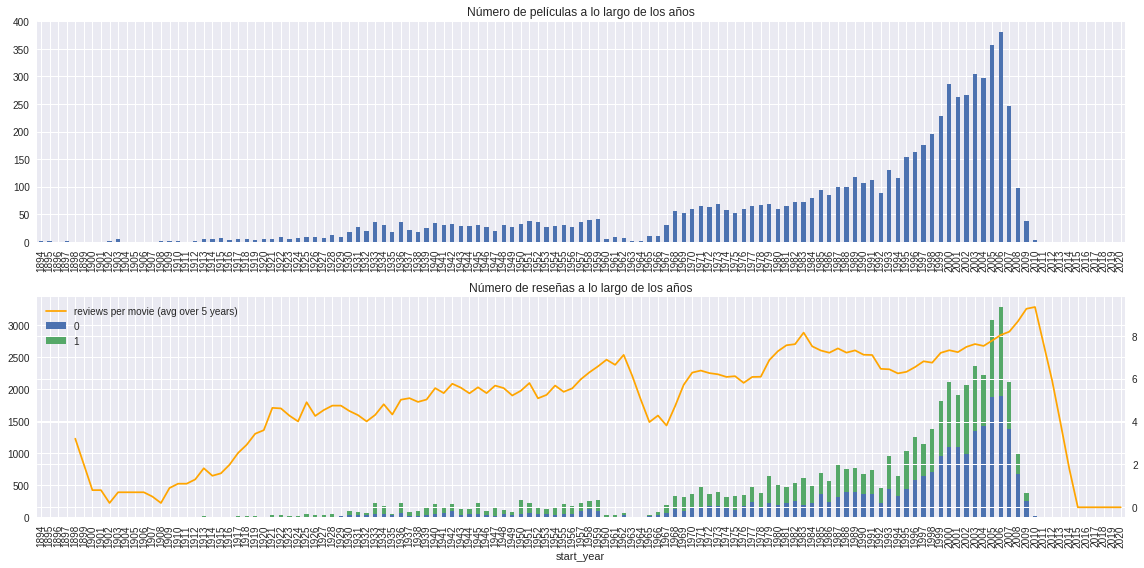

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
lines_1, labels_1 = ax.get_legend_handles_labels()

all_lines = [*lines, *lines_1]
all_labels = [*labels, *labels_1]
ax.legend(all_lines, all_labels, loc='upper left')
ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

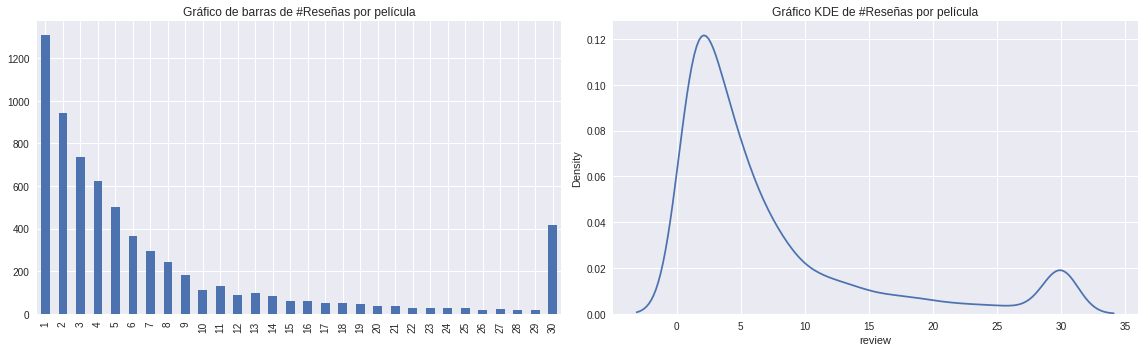

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

<font color=green>
Tenemos una distribución bien equilibrada entre reseñas positivas y negativas. No necesitamos equilibrar estas clases.
</font>

In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

<AxesSubplot:xlabel='pos', ylabel='count'>

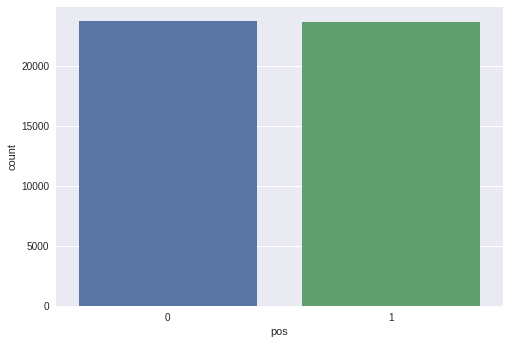

In [15]:
#Mostremos un gráfico:
sns.countplot(df_reviews['pos'])

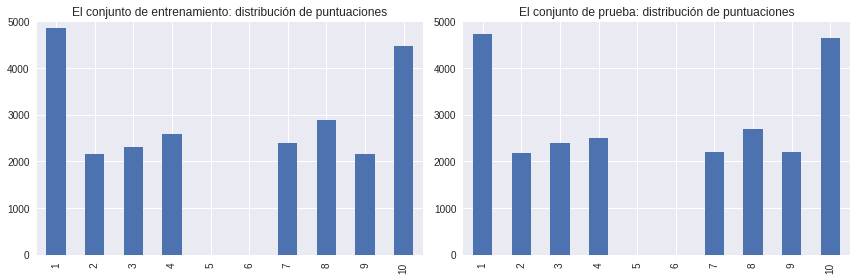

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

<font color=green>
Tanto el conjunto de entrenamiento, como de prueba, tienen muestras muy similares. Por lo tanto, no tenemos que preocuparnos con que las muestras nos puedan llevar a conclusiones erróneas.
    </font>

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

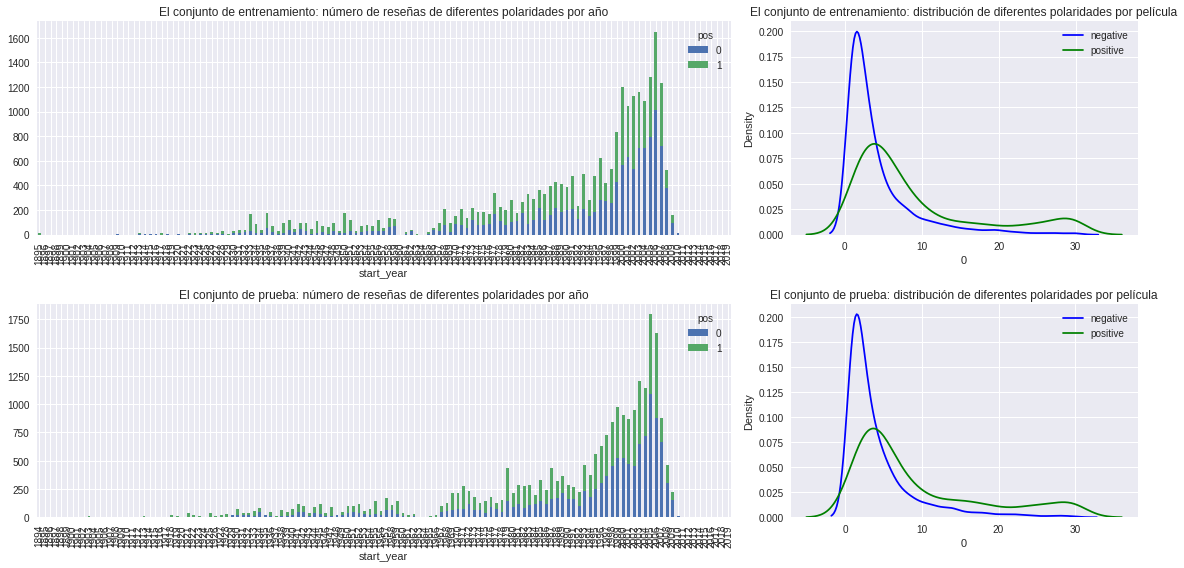

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

<font color=green>
Si bien, en este caso observamos una diferencia levemente más notoria, pero aún así siguen siendo muestras parecidas.
    </font>

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [18]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [19]:
#df_reviews['review_norm'] = ...# <escribe tu código aquí>

In [20]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clear_text(text):
    pattern = r"[^a-zA-Z']"
    text = re.sub(pattern, " ", text)
    return" ".join(text.split())

def lemmatize(text):
    doc = nlp(text.lower())
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
    return ' '.join(lemmas)

In [21]:
review_norm = []
for c in df_reviews['review']:
    review_norm.append(lemmatize(clear_text(c)))
    
df_reviews['review_norm'] = review_norm

<font color=green>
Veamos una comparación de cómo quedó nuestra función de limpieza de texto.
    </font>

In [22]:
#Antes
df_reviews['review'].head(2)

0    The pakage implies that Warren Beatty and Gold...
1    How the hell did they get this made?! Presenti...
Name: review, dtype: object

In [23]:
#Después
df_reviews['review_norm'].head(2)

0    the pakage imply that warren beatty and goldie...
1    how the hell do they get this make present its...
Name: review_norm, dtype: object

In [24]:
#Verificación si tiene misma cantidad de datos
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
 17  review_norm 

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [25]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

N=7000
train_features = df_reviews_train['review'].iloc[:N]
train_target = df_reviews_train['pos'].iloc[:N]

test_features = df_reviews_test['review'].iloc[:N]
test_target = df_reviews_test['pos'].iloc[:N]



print(train_features.shape)
print(test_target.shape)

(7000,)
(7000,)


In [26]:
train_features.head()

0    The pakage implies that Warren Beatty and Gold...
1    How the hell did they get this made?! Presenti...
7    This true story of Carlson's Raiders is more o...
8    Should have been titled 'Balderdash!' Little i...
9    The movie 'Gung Ho!': The Story of Carlson's M...
Name: review, dtype: object

In [27]:
test_target.value_counts()

0    3636
1    3364
Name: pos, dtype: int64

In [28]:
train_target.value_counts()

0    3624
1    3376
Name: pos, dtype: int64

## Trabajar con modelos

### Modelo 0 - Constante

In [29]:
dummy = DummyClassifier(strategy="constant", constant=1)
dummy.fit(train_features, train_target)

DummyClassifier(constant=1, strategy='constant')

In [30]:
metrics.accuracy_score(test_target, dummy.predict(test_features))

0.4805714285714286

          train  test
Accuracy   0.48  0.48
F1         0.65  0.65
APS        0.48  0.48
ROC AUC    0.50  0.50


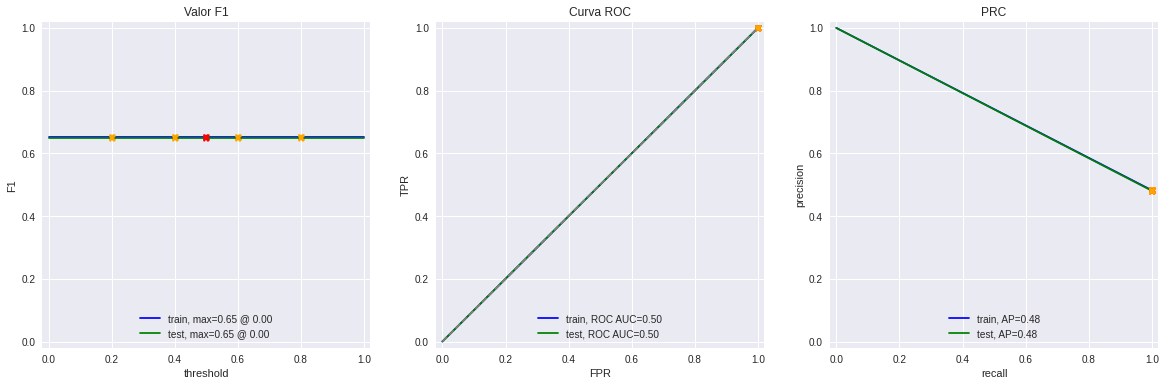

In [31]:
evaluate_model(dummy, train_features, train_target, test_features, test_target)

<font color=green>
Nuestro modelo Dummy, nos da un valor F1 de 0.65 en el conjunto de test, que es muy por debajo del mínimo.
    </font>

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [32]:
#Preprocesamiento
def preprocess_text(text):
    pattern = r"[^a-zA-z']+"
    text = re.sub(pattern, " ", text).lower().strip()
    
    #Tokenización
    tokens = nltk.word_tokenize(text)
    
    #Removemos stopwords
    stop_words = set(stopwords.words('english'))
    
    #Lematización
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    #Unión de tokens preprocesados
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

#Aplicación de preprocesamiento al conjunto de datos
train_features_nlkt = train_features.apply(preprocess_text)
test_features_nlkt = test_features.apply(preprocess_text)

#Creación de vectorización TF-IDF
vectorizer = TfidfVectorizer()
train_tfidf = vectorizer.fit_transform(train_features_nlkt)
test_tfidf = vectorizer.transform(test_features_nlkt)

# Crear el modelo de regresión logística
lr_model = LogisticRegression()

# Entrenar el modelo
lr_model.fit(train_tfidf, train_target)

# Definir los parámetros para GridSearchCV
# param_grid = {
#     'penalty': ['elasticnet'],
#     'solver': ['saga'],
#     'l1_ratio': list(np.arange(0, 1.1, 1 / 2)),
#     'C': list(np.arange(0.001, 1.1, 1 / 2))
# }
param_grid = {
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': list(np.arange(0, 1.1, 0.1)),
    'C': list(np.arange(0.01, 2.01, 0.1))
}


# Crear el estimador con el modelo y los parámetros para GridSearchCV
nltk_tfidf_lr = GridSearchCV(lr_model, param_grid=param_grid, scoring='f1', cv=2, verbose=3, refit=True)

In [33]:
nltk_tfidf_lr.fit(train_tfidf, train_target)

Fitting 2 folds for each of 220 candidates, totalling 440 fits
[CV 1/2] END C=0.01, l1_ratio=0.0, penalty=elasticnet, solver=saga; total time=   0.3s
[CV 2/2] END C=0.01, l1_ratio=0.0, penalty=elasticnet, solver=saga; total time=   0.3s
[CV 1/2] END C=0.01, l1_ratio=0.1, penalty=elasticnet, solver=saga; total time=   0.3s
[CV 2/2] END C=0.01, l1_ratio=0.1, penalty=elasticnet, solver=saga; total time=   0.3s
[CV 1/2] END C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=saga; total time=   0.1s
[CV 2/2] END C=0.01, l1_ratio=0.2, penalty=elasticnet, solver=saga; total time=   0.1s
[CV 1/2] END C=0.01, l1_ratio=0.30000000000000004, penalty=elasticnet, solver=saga; total time=   0.1s
[CV 2/2] END C=0.01, l1_ratio=0.30000000000000004, penalty=elasticnet, solver=saga; total time=   0.1s
[CV 1/2] END C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=saga; total time=   0.1s
[CV 2/2] END C=0.01, l1_ratio=0.4, penalty=elasticnet, solver=saga; total time=   0.1s
[CV 1/2] END C=0.01, l1_ratio=0.5, 

GridSearchCV(cv=2, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.11, 0.21000000000000002,
                               0.31000000000000005, 0.41000000000000003, 0.51,
                               0.6100000000000001, 0.7100000000000001, 0.81,
                               0.91, 1.01, 1.11, 1.2100000000000002, 1.31,
                               1.4100000000000001, 1.51, 1.61,
                               1.7100000000000002, 1.81, 1.9100000000000001],
                         'l1_ratio': [0.0, 0.1, 0.2, 0.30000000000000004, 0.4,
                                      0.5, 0.6000000000000001,
                                      0.7000000000000001, 0.8, 0.9, 1.0],
                         'penalty': ['elasticnet'], 'solver': ['saga']},
             scoring='f1', verbose=3)

          train  test
Accuracy   0.96  0.86
F1         0.96  0.85
APS        0.99  0.93
ROC AUC    0.99  0.94


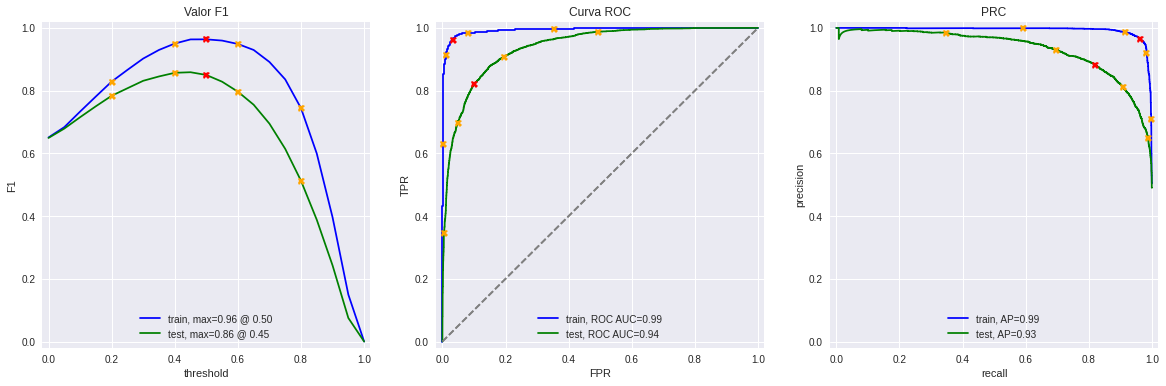

In [34]:
evaluate_model(nltk_tfidf_lr, train_tfidf, train_target, test_tfidf, test_target)

<font color=green>
Nuestro modelo de NLTK, TF-IDF y LR, presenta un Valor F1 del mínimo requerido en el conjunto de Test.
    </font>

### Modelo 3 - spaCy, TF-IDF y LR

In [35]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [36]:
def text_preprocessing_3(text_1):
 
    
    doc = nlp(text_1)
    
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

#Preprocesamiento de texto con spacy
train_features_spacy = train_features.apply(text_preprocessing_3)
test_features_spacy = test_features.apply(text_preprocessing_3)

#Creación de vectorización TF-IDF
vectorizer = TfidfVectorizer()
train_spacy_tfidf = vectorizer.fit_transform(train_features_spacy)
test_spacy_tfidf = vectorizer.transform(test_features_spacy)

#Modelo de regresión logística
lr_model_spacy = LogisticRegression()

# Definir el pipeline con el vectorizador TF-IDF y el modelo de regresión logística
pipeline = Pipeline([
    ('vectorizer', vectorizer),
    ('model', lr_model_spacy)
])

# Definir los parámetros para GridSearchCV
param_grid = {
    'model__penalty': ['elasticnet'],
    'model__solver': ['saga'],
    'model__l1_ratio': list(np.arange(0, 1.1, 1/2)),
    'model__C': list(np.arange(0.001, 1.1, 1/2))
}
# Realizaamos la búsqueda de hiperparámetros utilizando GridSearchCV
spacy_tfidf_lr = GridSearchCV(pipeline, param_grid=param_grid, scoring='accuracy', cv=5)

In [37]:
# print(type(train_spacy_tfidf))

In [38]:
spacy_tfidf_lr.fit(train_features_spacy, train_target)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [0.001, 0.501, 1.001],
                         'model__l1_ratio': [0.0, 0.5, 1.0],
                         'model__penalty': ['elasticnet'],
                         'model__solver': ['saga']},
             scoring='accuracy')

          train  test
Accuracy   0.95  0.86
F1         0.94  0.85
APS        0.99  0.93
ROC AUC    0.99  0.94


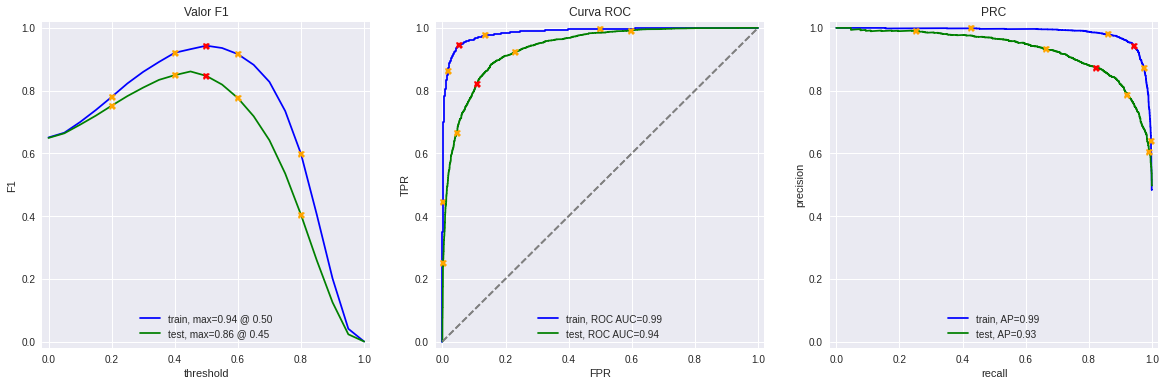

In [39]:
evaluate_model(spacy_tfidf_lr, train_features_spacy, train_target, test_features_spacy, test_target)

<font color=green>
Nuestro modelo de spaCY, TF-IDF y LR, presenta un buen valor en el conjunto de Test al igual que el modelo anterior. 
    </font>

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [40]:
# Función de preprocesamiento de texto con spaCy
def text_preprocessing_4(text_2):
    doc = nlp(text_2)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)


# Preprocesamiento de texto con spaCy
train_features_lgbm = train_features.apply(text_preprocessing_4)
test_features_lgbm = test_features.apply(text_preprocessing_4)

# Crear el vectorizador TF-IDF
vectorizer = TfidfVectorizer()
train_tfidf_lgbm = vectorizer.fit_transform(train_features_lgbm)
test_tfidf_lgbm = vectorizer.transform(test_features_lgbm)

# Crear el modelo LGBMClassifier
lgbm_model = LGBMClassifier()

# Definir los parámetros para GridSearchCV
# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.5],
#     'max_depth': [5, 7, 9],
#     'num_leaves': [15, 31, 63],
#     'subsample': [0.8, 0.9, 1.0]
# }
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [5, 15, 20],
    'num_leaves': [50, 100, 150],
    'subsample': [0.6, 0.7, 0.8]
}

# Realizaamos la búsqueda de hiperparámetros utilizando GridSearchCV
spacy_tfidf_lgbm = GridSearchCV(lgbm_model, param_grid=param_grid, scoring='accuracy', cv=5)

In [ ]:
spacy_tfidf_lgbm.fit(train_tfidf_lgbm, train_target)

In [ ]:
evaluate_model(spacy_tfidf_lgbm, train_tfidf_lgbm, train_target, test_tfidf_lgbm, test_target)

<font color=green>
Nuestro modelo de spaCY, TF-IDF y LGBMClassifier, presenta un buen resultado. Pero sigue bajo el mínimo requerido.
    </font>

###  Modelo 9 - BERT

In [ ]:
# import torch
# import transformers

In [ ]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#     ids_list = []
#     attention_mask_list = []

#     # texto al id de relleno de tokens junto con sus máscaras de atención 
       
#     # <escribe tu código aquí para crear ids_list y attention_mask_list>
    
#     if force_device is not None:
#         device = torch.device(force_device)
#     else:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#     model.to(device)
#     if not disable_progress_bar:
#         print(f'Uso del dispositivo {device}.')
    
#     # obtener insertados en lotes
    
#     embeddings = []

#     for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#         ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
#         # <escribe tu código aquí para crear attention_mask_batch
            
#         with torch.no_grad():            
#             model.eval()
#             batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#         embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
#     return np.concatenate(embeddings)

In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
# train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
# print(df_reviews_train['review_norm'].shape)
# print(train_features_9.shape)
# print(train_target.shape)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Mis reseñas

In [ ]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""


def cleaning_text(text_3):
    cleaning_text = re.sub(r'[^a-zA-Z\s\']', '', text_3) #Elimina caracteres que no sean letras, espacios o apostrofes
    cleaning_text = " ".join(cleaning_text.split()) #Elimina espacios adicionales
    
    return cleaning_text

def preprocess_text_with_nltk(text_3):
    #Convierte en minúsculas
    text_3 = text_3.lower()
    
    #Elimina dígitos y signos de puntuación y caracteres especiales
    text_3 = re.sub(r'\d+', '', text_3)
    text_3 = text_3.translate(str.maketrans('','', string.punctuation))
    
    #Tokenización de palabras
    words = word_tokenize(text_3)
    
    #Elimina stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    #Lematización
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    #Unir las palabras preprocesadas en un texto nuevamente
    preprocessed_text = ''.join(words)
    
    return preprocessed_text


my_reviews['review_norm'] = my_reviews['review'].apply(cleaning_text).apply(preprocess_text_with_nltk) # <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>

my_reviews

### Modelo 2

In [ ]:
texts = my_reviews['review_norm']


tfidf_vectorizer_2 = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer_2.fit_transform(train_features)

model_2 = LogisticRegression()
model_2.fit(X_train_tfidf, train_target)

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

def text_preprocessing_3(texts):
 
    
    doc = nlp(texts)
    
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

tfidf_vectorizer_3 = TfidfVectorizer()
X_train_tfidf_1 = tfidf_vectorizer_3.fit_transform(train_features)
model_3 = LogisticRegression()
model_3.fit(X_train_tfidf_1, train_target)

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = TfidfVectorizer()
X_train_tfidf_2 = tfidf_vectorizer_3.fit_transform(train_features)


model_4 = LGBMClassifier()
model_4.fit(X_train_tfidf_2, train_target)

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Modelo 9

In [ ]:
# texts = my_reviews['review_norm']

# my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# for i, review in enumerate(texts.str.slice(0, 100)):
#     print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

<font color=green>
Al aplicar los 3 modelos a la reseña, observamos que el output de dichos modelos, es el mismo en todos.
    </font>

## Conclusiones

En primera instancia, se hizo un pequeño EDA, para ver si los datos proveidos estaban completos o no. Se descubrió 2 filas con datos faltantes, por lo que decidí eliminarlos. Comprobamos si teníamos un buen equilibrio de datos entre ambos conjuntos. Después comprobamos la distribución entre reseñas positivas y negativas, estando estas bien equilibradas y necesario de equilibrar estas clases. Normalizamos nuestros Datasets y empezamos con los modelos.

Empecé con poca cantidad de ejemplos, para ver como reaccionaban los modelos. Al principio tuve un pequeño problema con los modelos, ya que no me mostraban valor en "ACCURACY", teniendo que corregir una parte en el código de la función pre-hecha.

Tuve que ajustar los hiperparámetros y subir la cantidad de datos para poder llegar al valor mínimo de F1. Pudiendo cumplirlo con `N = 6000`. Logrando en 2 modelos un valor F1 de 0.85. Siendo estos los modelos `NLTK, TF-IDF y LR` y `Spacy, TF-IDF y LR`. El tercer modelo, subió un poco, pero no logrando llegar al mínimo requerido.